In [1]:
import sys
!{sys.executable} -m pip install datasets

In [2]:
!pip install --upgrade transformers

In [3]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
!pip install transformers

In [5]:
import transformers
print(transformers.__version__)
print(transformers.__file__)


4.51.3
/opt/conda/lib/python3.10/site-packages/transformers/__init__.py


In [6]:
from transformers import TrainingArguments

print(TrainingArguments.__module__)  # Confirm it's from transformers.training_args


transformers.training_args


In [7]:
from transformers import TrainingArguments
import inspect

# Show signature of the __init__ method
print(inspect.signature(TrainingArguments.__init__))


(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict, str, NoneType] = <factory>, warmup_ratio: float = 0.0, warmup_ste

In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
from datasets import load_dataset

dataset = load_dataset("casehold/casehold")


In [10]:
# Access each split
train_data = dataset["train"].select(range(3000))
val_data = dataset["validation"].select(range(500))
test_data = dataset["test"].select(range(500))

In [11]:
print(f'Train size: {len(train_data)}')
print(f'Validation size: {len(val_data)}')
print(f'Test size: {len(test_data)}')

Train size: 3000
Validation size: 500
Test size: 500


In [12]:
import pandas as pd

df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)
df_test = pd.DataFrame(test_data)

df_train.drop(columns=['example_id'], inplace=True)
df_val.drop(columns=['example_id'], inplace=True)
df_test.drop(columns=['example_id'], inplace=True)

df_train['label'] = df_train['label'].astype(int)
df_val['label'] = df_val['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)

print(df_train.head())

                                       citing_prompt  \
0  Drapeau’s cohorts, the cohort would be a “vict...   
1  Colameta used customer information that he too...   
2  property tax sale. In reviewing section 6323(b...   
3  They also rely on Oswego Laborers’ Local 214 P...   
4  did not affect the defendant’s guideline range...   

                                           holding_0  \
0  holding that possession of a pipe bomb is a cr...   
1  recognizing that even if a plaintiff claims ce...   
2  holding that where there is a conflict between...   
3  holding that plaintiff stated a  349 claim whe...   
4  holding that united states v booker 543 us 220...   

                                           holding_1  \
0  holding that bank robbery by force and violenc...   
1  holding that included among trade secrets empl...   
2  holding that specific statutory provisions tak...   
3  holding that plaintiff stated a claim for brea...   
4  holding that waiver of right to appeal sent

In [13]:
columns = df_train.columns.tolist()
print(columns)

['citing_prompt', 'holding_0', 'holding_1', 'holding_2', 'holding_3', 'holding_4', 'label']


In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from datasets import load_dataset

model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Make sure padding tokens are defined
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))

# Example dataset preparation for GPT-style input
def preprocess_gpt(example):
    input_prompt = example['prompt']
    choices = example['choices']
    label = example['label']

    # Concatenate prompt with each choice
    inputs = [f"{input_prompt} {c}" for c in choices]
    encoded = tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')

    # Language modeling: We can treat the correct choice as the target output
    target = tokenizer(f"{input_prompt} {choices[label]}", return_tensors='pt')['input_ids']

    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'labels': target
    }

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, GPT2Tokenizer, GPT2LMHeadModel
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [16]:
class CaseHoldDataset(Dataset):
    def __init__(self, df, tokenizer, model_type='t5', max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.model_type = model_type
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        prompt = row['citing_prompt']
        choices = [row[f'holding_{i}'] for i in range(5)]
        label = row['label']

        inputs = [f"{prompt} {c}" for c in choices]
        tokenized = self.tokenizer(inputs, return_tensors='pt', padding='max_length',
                                  max_length=self.max_length, truncation=True)
        return {
            "input_ids": tokenized["input_ids"],          # shape: [5, seq_len]
            "attention_mask": tokenized["attention_mask"],# shape: [5, seq_len]
            "label": torch.tensor(label, dtype=torch.long)
        }

In [17]:
def get_dataloaders(df_train, df_val, df_test, tokenizer, model_type, batch_size=8):
    train_ds = CaseHoldDataset(df_train, tokenizer, model_type)
    val_ds = CaseHoldDataset(df_val, tokenizer, model_type)
    test_ds = CaseHoldDataset(df_test, tokenizer, model_type)

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds, batch_size=1),
        DataLoader(test_ds, batch_size=1)
    )

In [18]:
def evaluate_gpt2(model, dataloader, tokenizer):
    model.eval()
    model.to(device)

    dot_token_id = tokenizer.encode(".")[0]  # Get the token ID for "."

    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)          # shape: [batch, 5, seq_len]
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            batch_size = input_ids.size(0)

            for i in range(batch_size):
                input_ids_i = input_ids[i]                     # shape: [5, seq_len]
                attention_mask_i = attention_mask[i]           # shape: [5, seq_len]
                dot_probs = []

                for j in range(5):
                    outputs = model(input_ids=input_ids_i[j].unsqueeze(0),
                                    attention_mask=attention_mask_i[j].unsqueeze(0))
                    logits = outputs.logits                   # shape: [1, seq_len, vocab_size]
                    last_token_logits = logits[0, -1, :]      # shape: [vocab_size]
                    prob_dot = torch.softmax(last_token_logits, dim=0)[dot_token_id]
                    dot_probs.append(prob_dot.item())

                pred = torch.argmax(torch.tensor(dot_probs))
                if pred.item() == labels[i].item():
                    correct += 1
                total += 1

    print(f"Eval Accuracy: {correct}/{total} = {correct / total:.4f}")
    return correct / total

In [19]:
import os

def train_gpt2(model, train_loader, eval_loader, epochs=5, lr=5e-5, model_path="best_gpt2_model.pt"):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    eval_accuracies = []
    train_losses = []
    best_acc = 0.0

    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        model.load_state_dict(torch.load(model_path))

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            batch_size = input_ids.size(0)
            losses = []
            for i in range(batch_size):
                logits = model(input_ids=input_ids[i], attention_mask=attention_mask[i]).logits
                last_token_logits = logits[:, -1, :]  # [num_choices, vocab_size]
                probs = torch.softmax(last_token_logits[:, tokenizer.encode(".")[0]], dim=0)  # simplistic
                loss = -torch.log(probs[labels[i]])
                losses.append(loss)

            loss = torch.stack(losses).mean()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")
        eval_acc = evaluate_gpt2(gpt_model, eval_loader, gpt_tokenizer)
        eval_accuracies.append(eval_acc)

        if eval_acc > best_acc:
            best_acc = eval_acc
            torch.save(model.state_dict(), model_path)
            print(f"Saved better model (Eval Accuracy: {eval_acc:.4f})")

    return train_losses, eval_accuracies

In [20]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
gpt_model = GPT2LMHeadModel.from_pretrained("distilgpt2")
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
gpt_model.resize_token_embeddings(len(gpt_tokenizer))

train_loader, eval_loader, test_loader = get_dataloaders(df_train, df_val, df_test, gpt_tokenizer, "gpt2")

In [21]:
train_losses, eval_accuracies = train_gpt2(gpt_model, train_loader, eval_loader, epochs=5, lr=5e-5)

100%|██████████| 375/375 [20:02<00:00,  3.21s/it]


Epoch 1, Train Loss: 1.8238


100%|██████████| 500/500 [01:12<00:00,  6.92it/s]


Eval Accuracy: 186/500 = 0.3720
Saved better model (Eval Accuracy: 0.3720)


100%|██████████| 375/375 [20:04<00:00,  3.21s/it]


Epoch 2, Train Loss: 1.0300


100%|██████████| 500/500 [01:11<00:00,  7.03it/s]


Eval Accuracy: 274/500 = 0.5480
Saved better model (Eval Accuracy: 0.5480)


100%|██████████| 375/375 [20:04<00:00,  3.21s/it]


Epoch 3, Train Loss: 0.8235


100%|██████████| 500/500 [01:11<00:00,  7.03it/s]


Eval Accuracy: 276/500 = 0.5520
Saved better model (Eval Accuracy: 0.5520)


100%|██████████| 375/375 [20:04<00:00,  3.21s/it]


Epoch 4, Train Loss: 0.6552


100%|██████████| 500/500 [01:11<00:00,  7.02it/s]


Eval Accuracy: 272/500 = 0.5440


100%|██████████| 375/375 [20:03<00:00,  3.21s/it]


Epoch 5, Train Loss: 0.4750


100%|██████████| 500/500 [01:11<00:00,  7.04it/s]


Eval Accuracy: 285/500 = 0.5700
Saved better model (Eval Accuracy: 0.5700)


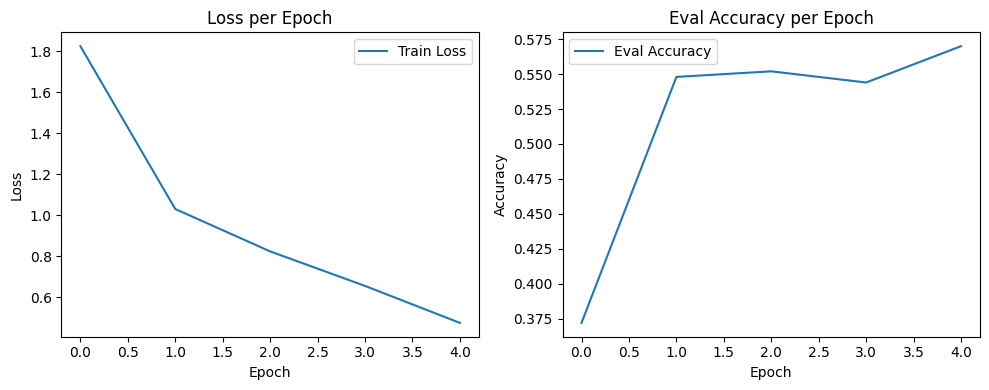

In [22]:
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_accuracies, label="Eval Accuracy")
plt.title("Eval Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

def evaluate_gpt2_testset(model, dataloader, tokenizer):
    model.eval()
    model.to(device)

    dot_token_id = tokenizer.encode(".")[0]

    all_preds = []
    all_labels = []
    skipped = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating GPT-2 on Test Set"):
            input_ids = batch['input_ids'].to(device)          # shape: [batch, 5, seq_len]
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            batch_size = input_ids.size(0)

            for i in range(batch_size):
                try:
                    input_ids_i = input_ids[i]                # [5, seq_len]
                    attention_mask_i = attention_mask[i]
                    dot_probs = []

                    for j in range(5):
                        outputs = model(
                            input_ids=input_ids_i[j].unsqueeze(0),
                            attention_mask=attention_mask_i[j].unsqueeze(0)
                        )
                        logits = outputs.logits               # [1, seq_len, vocab_size]
                        last_token_logits = logits[0, -1, :]  # [vocab_size]
                        prob_dot = torch.softmax(last_token_logits, dim=0)[dot_token_id]
                        dot_probs.append(prob_dot.item())

                    pred = torch.argmax(torch.tensor(dot_probs))
                    all_preds.append(pred.item())
                    all_labels.append(labels[i].item())

                except:
                    skipped += 1

    if not all_labels:
        print("❌ No valid predictions.")
        return None

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("\n📊 Final GPT-2 Test Set Evaluation:")
    print(f"Accuracy:           {accuracy:.4f}")
    print(f"Macro Precision:    {precision:.4f}")
    print(f"Macro Recall:       {recall:.4f}")
    print(f"Macro F1-score:     {f1:.4f}")
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall:    {weighted_recall:.4f}")
    print(f"Weighted F1-score:  {weighted_f1:.4f}")
    print(f"Skipped Samples:    {skipped}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, digits=4))
    print("Confusion Matrix:\n", conf_matrix)

    return {
        "accuracy": accuracy,
        "macro_f1": f1,
        "weighted_f1": weighted_f1,
        "confusion_matrix": conf_matrix,
        "skipped": skipped
    }

In [24]:
evaluate_gpt2_testset(gpt_model, test_loader, gpt_tokenizer)

Evaluating GPT-2 on Test Set: 100%|██████████| 500/500 [01:11<00:00,  7.02it/s]


📊 Final GPT-2 Test Set Evaluation:
Accuracy:           0.5380
Macro Precision:    0.5348
Macro Recall:       0.5387
Macro F1-score:     0.5351
Weighted Precision: 0.5419
Weighted Recall:    0.5380
Weighted F1-score:  0.5385
Skipped Samples:    0

Classification Report:
               precision    recall  f1-score   support

           0     0.4526    0.5584    0.5000        77
           1     0.5943    0.6117    0.6029       103
           2     0.5400    0.4865    0.5118       111
           3     0.4945    0.4945    0.4945        91
           4     0.5926    0.5424    0.5664       118

    accuracy                         0.5380       500
   macro avg     0.5348    0.5387    0.5351       500
weighted avg     0.5419    0.5380    0.5385       500

Confusion Matrix:
 [[43 12  9  5  8]
 [11 63  8 13  8]
 [16 12 54 17 12]
 [ 7  8 15 45 16]
 [18 11 14 11 64]]


{'accuracy': 0.538,
 'macro_f1': 0.535119266110156,
 'weighted_f1': 0.5384854361275224,
 'confusion_matrix': array([[43, 12,  9,  5,  8],
        [11, 63,  8, 13,  8],
        [16, 12, 54, 17, 12],
        [ 7,  8, 15, 45, 16],
        [18, 11, 14, 11, 64]]),
 'skipped': 0}

In [25]:
torch.cuda.empty_cache()

In [26]:
!nvidia-smi

Mon May  5 22:22:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             49W /   70W |     493MiB /  15360MiB |     92%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
